# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# !pip install subword-nmt nltk torchtext
# !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

In [1]:
import math
import time
from copy import deepcopy
from importlib import reload
from sys import modules

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from IPython.display import clear_output
from nltk.tokenize import WordPunctTokenizer
from torchtext.data import Field, BucketIterator
from torchtext.data.utils import get_tokenizer

import csv
from pickle import dump, load
from spacy.lang.ru import Russian

import my_network

matplotlib.rcParams.update(
    {'figure.figsize': (16, 12), 'font.size': 14}
)

In [2]:
from tokenizers import BertWordPieceTokenizer, SentencePieceBPETokenizer  # conda install -c powerai tokenizers

In [3]:
# with open('data.txt', 'r') as out:
#     english_corpus, russian_corpus = zip(*csv.reader(out, delimiter='\t'))

# COMMON_TOKENS = '!"#$%&\'()*+,-./;:><=?@[]\^_~`{}0123456789'
# BERT_TOKENS = '[PAD]\n[UNK]\n[CLS]\n[SEP]\n[MASK]\n'

# with open('english_corpus.txt', 'w') as out:
#     #out.write(BERT_TOKENS)
#     out.writelines(char + '\n' for char in COMMON_TOKENS)
#     out.writelines(map(lambda x: '\n'.join(x.lower().split()) + '\n', english_corpus))

# with open('russian_corpus.txt', 'w') as out:
#     #out.write(BERT_TOKENS)
#     out.writelines(char + '\n' for char in COMMON_TOKENS)
#     out.writelines(map(lambda x: '\n'.join(x.lower().split()) + '\n', russian_corpus))

# del english_corpus, russian_corpus

In [4]:
!tail russian_corpus.txt

прочих
удобств
полностью
укомплектованная
кухня
и
собственная
ванная
комната
.


In [5]:
!tail english_corpus.txt

a
tv,
a
fully
equipped
kitchen
and
a
private
bathroom.


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [6]:
COMMON_TOKENS = '!"#$%&\'()*+,-./;:><=?@[]\^_~`{}0123456789'
BERT_TOKENS = '[PAD]\n[UNK]\n[CLS]\n[SEP]\n[MASK]\n'

In [8]:
with open('eng_tokens.txt', 'a') as out:
    out.writelines(char + '\n' for char in COMMON_TOKENS)
    #out.write(BERT_TOKENS)
with open('rus_tokens.txt', 'a') as out:
    out.writelines(char + '\n' for char in COMMON_TOKENS)
    #out.write(BERT_TOKENS)

In [9]:
%%time
tokenizer_R = SentencePieceBPETokenizer(replacement='@@')
tokenizer_E = SentencePieceBPETokenizer(replacement='@@')
tokenizer_R.train('rus_tokens.txt', vocab_size=50000)
tokenizer_E.train('eng_tokens.txt', vocab_size=50000)

# w = WordPunctTokenizer()
# def tokenize_russian(x, tokenizer=tokenizer_R):
#     return tokenizer.tokenize(x.lower())
def make_tokenize_func(tokenizer):
    def tokenize(sentence):
        return tokenizer.encode(sentence.lower()).tokens
    return tokenize

tokenize_russian = make_tokenize_func(tokenizer_R)
tokenize_english = make_tokenize_func(tokenizer_E)

print(tokenizer_R)
print(tokenizer_E)

Tokenizer(vocabulary_size=50000, model=SentencePieceBPE, unk_token=<unk>, replacement=@@, add_prefix_space=True, dropout=None)
Tokenizer(vocabulary_size=50000, model=SentencePieceBPE, unk_token=<unk>, replacement=@@, add_prefix_space=True, dropout=None)
CPU times: user 5h 3min 45s, sys: 23min 5s, total: 5h 26min 51s
Wall time: 4h 46min 51s


In [15]:
#tokenizer_E = SentencePieceBPETokenizer(replacement='^')
#tokenizer_E.train('english_corpus.txt', vocab_size=30000)

# def tokenize_english(x, tokenizer=w):
#     return tokenizer.encode(x.lower()).tokens
# def tokenize_english(x, tokenizer=w):
#     return tokenizer.tokenize(x.lower())
#tokenizer_E

In [11]:
SRC = Field(
    tokenize=tokenize_russian,
    init_token='<sos>',
    eos_token='<eos>',
    lower=True
)

TRG = Field(
    tokenize=tokenize_english,
    init_token='<sos>',
    eos_token='<eos>',
    lower=True
)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=(('trg', TRG), ('src', SRC))
)

In [12]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [13]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [14]:
SRC.build_vocab(train_data)
TRG.build_vocab(train_data)

In [15]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 19130
Unique tokens in target (en) vocabulary: 17655


Here are tokens from original (RU) corpus:

In [16]:
SRC.vocab.itos[::1000]

['<unk>',
 'вый',
 '@гара',
 'мас',
 '@гро',
 '@раба',
 'щая',
 '@тех',
 'ów',
 'bel',
 '@лицензи',
 'хина',
 '@лань',
 'hs',
 '@ord',
 '@дил',
 '@называемых',
 '@светлана',
 'cker',
 'хито']

And from target (EN) corpus:

In [17]:
TRG.vocab.itos[::1000]

['<unk>',
 'ico',
 '@dr',
 '@kat',
 'agar',
 '@cust',
 '@tennessee',
 '@wilder',
 '@lodging',
 'urne',
 '@kiz',
 '@weber',
 '@anglesey',
 '@durg',
 '@kwan',
 '@pál',
 '@vish',
 'kim']

And here is example from train dataset:

In [18]:
print(vars(train_data.examples[9]))

{'trg': ['@extras', '@include', '@bath', '@robes', '@sl', 'ippers', '@and', '@free', '@toilet', 'ries'], 'src': ['@го', 'стям', '@предоста', 'вляются', '@хала', 'ты', '@та', 'по', 'чки', '@и', '@беспла', 'тные', '@туалет', 'но', 'кос', 'ме', 'тические', '@принадлежности']}


Let's check the length distributions:

Length distribution in Train data


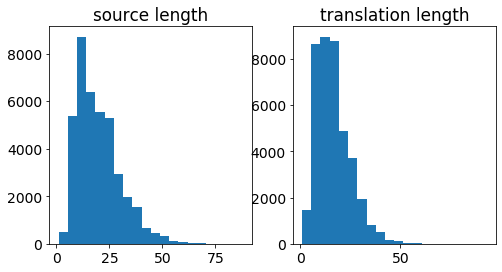

In [19]:
src_length = map(lambda x: len(x.src), train_data.examples)
trg_length = map(lambda x: len(x.trg), train_data.examples)

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(np.fromiter(src_length, dtype=int), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(np.fromiter(trg_length, dtype=int), bins=20);

Length distribution in Test data


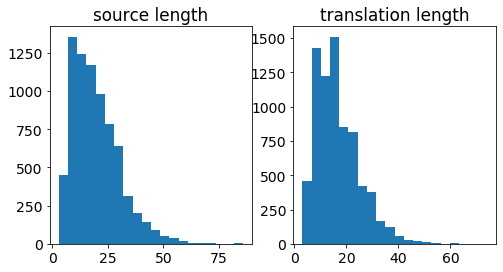

In [20]:
src_length = map(lambda x: len(x.src), test_data.examples)
trg_length = map(lambda x: len(x.trg), test_data.examples)

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(np.fromiter(src_length, dtype=int), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(np.fromiter(trg_length, dtype=int), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [21]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [22]:
device

device(type='cuda', index=1)

In [23]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key
)

In [24]:
iter(train_iterator)
x = next(iter(train_iterator))
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 39x128 (GPU 1)]
	[.src]:[torch.cuda.LongTensor of size 54x128 (GPU 1)]
torch.Size([54, 128]) torch.Size([39, 128])


In [26]:
#if 'my_network' in modules:
#    reload(my_network)

#import imp
#imp.reload(my_network)


Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq
#Trans = my_network.Trans

In [27]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 3
ENC_DROPOUT = 0.4
DEC_DROPOUT = 0.4

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [28]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19130, 256)
    (rnn): LSTM(256, 512, num_layers=3, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (re_embedding): Linear(in_features=512, out_features=512, bias=True)
      (softmax): Softmax(dim=0)
    )
    (embedding): Embedding(17655, 256)
    (rnn): LSTM(768, 512, num_layers=3, dropout=0.4)
    (out): Linear(in_features=2304, out_features=17655, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
  )
)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 62,981,879 trainable parameters


In [30]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [33]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0)
            #output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [35]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

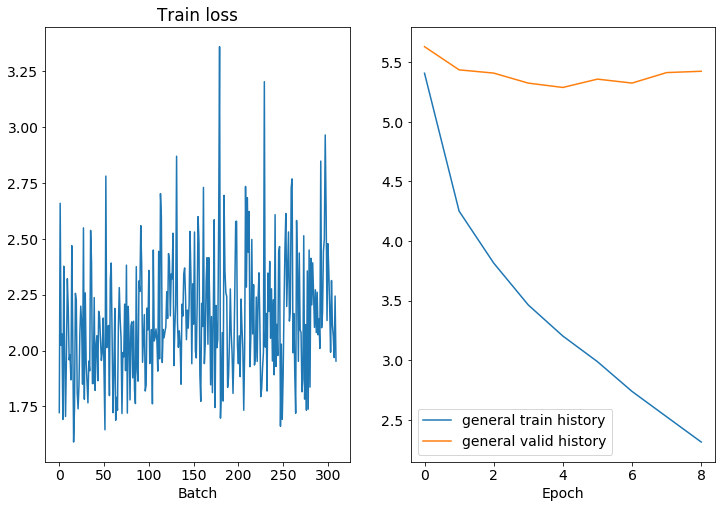

Epoch: 10 | Time: 3m 13s
	Train Loss: 2.137 | Train PPL:   8.473
	 Val. Loss: 5.566 |  Val. PPL: 261.306


In [37]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model-BPE.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [38]:
import utils
import imp

from typing import Iterable, Sequence

imp.reload(utils)

generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [50]:
def reduce_BPE_symbols(text: Iterable[str], prefix: str = '@') -> Sequence[str]:
    return list(
        filter(
            lambda arr: arr,
            ''.join(text).split(prefix)
        )
    )

In [51]:
batch = next(iter(test_iterator))

In [52]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: @the @bathroom @has @a @shower
Generated: arge @the @bathroom @comes @with @a @shower @bathroom @a @shower @a @shower

Original: @guests @can @enjoy @the @ons ite @restaurant
Generated: arge @guests @can @enjoy @the @ons ite @restaurant @site @site @site @site @site @site



In [53]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [54]:
import tqdm

In [55]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend(
            [get_text(x, TRG.vocab) for x in trg.cpu().numpy().T]
        )
        generated_text.extend(
            [get_text(x, TRG.vocab)[1:] for x in output.detach().cpu().numpy().T]
        )

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:05, 11.38it/s]


In [56]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

22.63247090422582

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points